### **Experiment Setup**
**There are 5 algorithms applied in our dataset:**
1. Tuned logistic regression
2. Principal Component Analysis and Logistic Regression
3. Random Forest Classifier 
4. Ensemble Gradient Boosting Classifier with tuned parameters
5. Stacking Algorithm with a logistic regression meta model (final classifier)

**These 5 algorithms are applied in 4 areas so that we can predict election winner outcomes in:**

 1.  Senate Seats
 2.  House Seats
 3.  Presidential Sets
 4.  All Seats (Senate, House, Presidential)
 
 **Algorithms 1 - 4 will produce 16 .pkl model files as shown below.**
 
 **Algorithm 5 will produce 1 Stacking Algorithm model using the 16 .pkl models and produce 4 .pkl model files for a total of 20 .pkl model files.**

 **All algorithms will use cross validation (k=5) to determine the best parameters for each model.**

 **All algorithms will use a holdout test set to determine the accuracy and f1 score. We will base our final model selection highest accuracy and f1 score.**
 

|Model #|Model Filename|Model Description
|--|--|--
|1|senate-tuned-lr|logistic regression on senate candidates with tuned hyperparameters
|2|house-tuned-lr|logistic regression on house candidates with tuned hyperparameters
|3|pres-tuned-lr|logistic regression on presidential candidates with tuned hyperparameters
|4|all-tuned-lr|logistic regression on all candidates with tuned hyperparameters
|5|senate-pca-lr|pca + logistic regression on senate candidates
|6|house-pca-lr|pca + logistic regression on house candidates
|7|pres-pca-lr|pca + logistic regression on presidential candidates
|8|all-pca-lr|pca + logistic regression on all candidates
|9|senate-rf|random forest classificer on senate candidates
|10|house-rf|random forest classificer on senate candidates
|11|pres-rf|random forest classificer on senate candidates
|12|all-rf|random forest classificer on senate candidates
|13|senate-gb|gradient boosting algo on senate candidates
|14|house-gb|gradient boosting algo on senate candidates
|15|pres-gb|gradient boosting algo on senate candidates
|16|all-gb|gradient boosting algo on senate candidates


**Comparison to baseline**

At the end of this notebook, we will compare our model to a classifier that only predicts on the majority class. This will be our baseline metric. We will prove that our model is better than the baseline model by showing that our model has a higher accuracy than the baseline model


**Libraries used**

- numpy for numerical analysis
- pandas for data manipulation
- matplotlib for data visualization
- seaborn for data visualization
- sklearn for machine learning algorithms
- pickle for saving models

**code snippet attribution**

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html : for grid search implementation
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html :  for lr implementation
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74:  for rf grid search implementation and the basis for gradient boosting implementation
- https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/ : for stacking implementation

---

### Experiment Setup and Data Preparation

Preprocessing of flattened feature engineered data can be referenced here:

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from datetime import datetime
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('data/all_features_candidate_summary_with_labels.csv')

In [102]:
df = df[df.CurrCand == 'Y']

cols = ['TotalGiftAmt','senate_seat','presidential_seat','house_seat','label']

df = df[cols]

In [103]:
#run function for data pre-processing
def pre_process(df):   
    
    #df = pd.get_dummies(df, columns=['run_for_state','run_for_district','cand_party'])
    #split x and y
    y = df['label']
    x = df.drop(['label'], axis=1)

    #remove collinear and redundant features as they can skew our Beta coefficients variables
    #if x has columned called 'Unnamed: 0'
    if 'Unnamed: 0' in x.columns:
        x = x.drop(['Unnamed: 0','CycleCands_x','curr_cand','RepeatDonorCount','CycleCands_y','challenger','FemaleDonorCount','TotalGiftAvg.1','open_office'], axis=1)
    else:
        try:
            x = x.drop(['curr_cand','RepeatDonorCount','challenger','FemaleDonorCount','TotalGiftAvg.1'], axis=1)
        except:
            pass

    #drop non numeric columns in x
    x = x.select_dtypes(include=['float64','int64','uint8','int32'])
      
    return x, y

In [104]:
df_senate = df[df['senate_seat'] == 1].copy()
df_presidential = df[df['presidential_seat'] == 1].copy()
df_house = df[df['house_seat'] == 1].copy()

Senate seat row count:  492
Presidential seat row count:  213
House seat row count:  4113
All row count:  4806


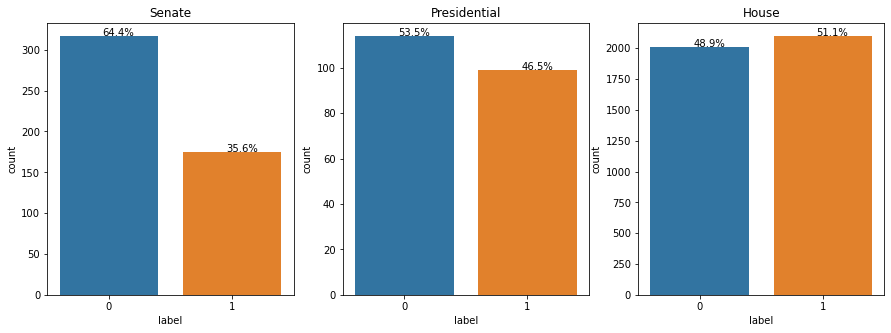

In [105]:
#print row count for each dataframe
print('Senate seat row count: ', df_senate.shape[0])
print('Presidential seat row count: ', df_presidential.shape[0])
print('House seat row count: ', df_house.shape[0])
print('All row count: ', df.shape[0])
%matplotlib inline 

#plot the distribution of the labels
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.countplot(x='label', data=df_senate, ax=ax[0])
sns.countplot(x='label', data=df_presidential, ax=ax[1])
sns.countplot(x='label', data=df_house, ax=ax[2])
#show percentage of labels in the plot
for i in range(3):
    total = len(df_senate) if i == 0 else len(df_presidential) if i == 1 else len(df_house)
    for p in ax[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax[i].annotate(percentage, (x, y))
ax[0].set_title('Senate')
ax[1].set_title('Presidential')
ax[2].set_title('House')
plt.show()

### Algorithm 1: Tuned Logistic Regression

---

**1a. Helper functions to run this task**

In [106]:
#helper functions for this task
def plot_correlation(x,y, set_name=None):
    ''' Function to plot correlation between features and labels '''
    correlation = x.corrwith(y)
    correlation = correlation.sort_values(ascending=False)

    plt.figure(figsize=(20,20))
    plt.barh(correlation.index, correlation.values)   
    plt.title(f'Correlation of Features with Target on {set_name} seats')
    plt.xlabel('Correlation')
    plt.savefig(f'plots/1-{set_name}-correlation-lr.png')
    #plt.show()

def grid_search_tuned_lr(x_train, y_train, cv=5):
    ''' Function to perform grid search on logistic regression '''
    logreg = LogisticRegression(max_iter=1000, tol=.001)
    std_scaler = StandardScaler()
    pipeline = make_pipeline(std_scaler, logreg)

    params = [
  {'logisticregression__penalty': ['l1'], 'logisticregression__solver': ['liblinear', 'sag','saga'], 'logisticregression__C': [0.01, 0.1, 1, 10], 'logisticregression__class_weight': ['balanced', None]},
  {'logisticregression__penalty': ['l2'], 'logisticregression__solver': ['lbfgs','newton-cg'],'logisticregression__C': [0.01, 0.1, 1, 10], 'logisticregression__class_weight': ['balanced', None]},
 ]
    

    grid = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    print('best score: ', grid.best_score_)
    print('best params: ', grid.best_params_)
    
    return grid

def fit_using_best_params_lr(x_train, y_train, grid_search = None):
    ''' function to fit the model using the best params from grid search '''
    if grid_search is not None:
        best_c = grid_search.best_params_['logisticregression__C']
        best_class_weight = grid_search.best_params_['logisticregression__class_weight']
        best_penalty = grid_search.best_params_['logisticregression__penalty']
        best_solver = grid_search.best_params_['logisticregression__solver']
        
    #save best params to a dictionary
    best_params = {'C':best_c, 'class_weight':best_class_weight, 'penalty':best_penalty}
    pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, C=best_c, class_weight=best_class_weight, solver=best_solver,penalty=best_penalty, tol=.001))
    pipeline.fit(x_train, y_train)  
    
    return pipeline, best_params
    

def get_feature_importance(pipeline, x_val, set_name = None):
    ''' Function to plot feature importance after logistic regression '''
   
    feature_importance = pipeline.steps[1][1].coef_[0]

    feature_names = x_val.columns
    feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':feature_importance})
    #sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(20,20))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.title(f'Feature Importance on {set_name} seats')
    plt.xlabel('Importance')     
    plt.savefig(f'plots/3-{set_name}-feature-importance-lr.png')
    #plt.show() 
    return feature_importance


#evaluate model function
def evaluate_model(model, x_train, y_train, x_val, y_val, set_name = None,best_params = None):
    ''' Function to evaluate model on train and validation set '''   
    #save accuracy, precision, recall, f1 score
    train_accuracy = model.score(x_train, y_train)
    val_accuracy = model.score(x_val, y_val)

    #predict on train and validation set
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)

    #recall
    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)

    #precision
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)

    #f1 score
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)  

    #save all metrics and best params to a dataframe
    metrics_df = pd.DataFrame({'experiment_name': f'Logistic Regression {set_name} seats', 
    'train_accuracy':[train_accuracy], 
    'test_accuracy':[val_accuracy], 
    'train_precision':[train_precision], 
    'test_precision':[val_precision],
    'train_recall':[train_recall], 
    'test_recall':[val_recall],      
    'train_f1':[train_f1], 
    'test_f1':[val_f1],
    'hyperparameters':[best_params]})    
    return metrics_df

def run_sequence_lr(x_train, y_train, x_val, y_val, set_name = None):
    #get correlation
    #correlation = plot_correlation(x_train, y_train, set_name)
    #label distribution
    #label_distribution(y_train, set_name)
    #grid search
    grid_search = grid_search_tuned_lr(x_train, y_train)
    #fit using best params
    model, best_params = fit_using_best_params_lr(x_train, y_train, grid_search)    
    #get feature importance
    feature_importance = get_feature_importance(model, x_train, set_name)
    #evaluate model
    metrics_df = evaluate_model(model, x_train, y_train, x_val, y_val, set_name=set_name, best_params=best_params)
    #save model to pickle
    model_name = f'models-currentcand/{set_name}-tuned-lr.pkl'
    pickle.dump(model, open(model_name, 'wb'))
    #add column to metrics_df called model_name on index 1
    metrics_df.insert(1, 'model_name', model_name)
    #display metrics_df dataframe
    display(metrics_df)     
    metrics_df.to_csv('models-currentcand/metrics-baseline.csv', mode='a', header=False, index=False)
    return model, metrics_df

metrics_df = pd.DataFrame(columns=['experiment_name', 
'model_name', 'train_accuracy', 
'test_accuracy', 'train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1', 'hyperparameters'])
filename = f'models-currentcand/metrics-baseline.csv'
metrics_df.to_csv(filename,index=False)

**1b. Run Logistic Regression sequence on senate seats**

In [107]:
%matplotlib agg 
%matplotlib agg 
x, y = pre_process(df_senate)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_lr(x_train, y_train, x_val, y_val, 'senate')

best score:  0.7175592340149302
best params:  {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression senate seats,models-currentcand/senate-tuned-lr.pkl,0.717557,0.676768,0.612903,0.576923,0.546763,0.416667,0.577947,0.483871,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}"


**1c. Run Logistic Regression sequence on house seats**

In [108]:
%matplotlib agg 
%matplotlib agg 
x, y = pre_process(df_house)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_lr(x_train, y_train, x_val, y_val, 'house')

best score:  0.6851063829787234
best params:  {'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression house seats,models-currentcand/house-tuned-lr.pkl,0.680851,0.675577,0.738024,0.733333,0.584816,0.557971,0.652548,0.633745,"{'C': 0.01, 'class_weight': None, 'penalty': 'l1'}"


**1d. Run Logistic Regression sequence on presidential seats**

In [109]:
%matplotlib agg 
%matplotlib agg
x, y = pre_process(df_presidential)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_lr(x_train, y_train, x_val, y_val, 'presidential')

best score:  0.5235294117647058
best params:  {'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression presidential seats,models-currentcand/presidential-tuned-lr.pkl,0.523529,0.581395,0.0,0.0,0.0,0.0,0.0,0.0,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}"


**1e. Run Logistic Regression sequence on all seats**

In [110]:
%matplotlib agg 
%matplotlib agg
x, y = pre_process(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_lr(x_train, y_train, x_val, y_val, 'all')

best score:  0.5759492170567838
best params:  {'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression all seats,models-currentcand/all-tuned-lr.pkl,0.527055,0.514553,0.513834,0.49642,0.88528,0.902386,0.65025,0.640493,"{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}"


**1f. Summary of results for Logistic Regression**

In [111]:
tuned_lr = pd.read_csv('models-currentcand/metrics-baseline.csv')
display(tuned_lr)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression senate seats,models-currentcand/senate-tuned-lr.pkl,0.717557,0.676768,0.612903,0.576923,0.546763,0.416667,0.577947,0.483871,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}"
1,Logistic Regression house seats,models-currentcand/house-tuned-lr.pkl,0.680851,0.675577,0.738024,0.733333,0.584816,0.557971,0.652548,0.633745,"{'C': 0.01, 'class_weight': None, 'penalty': 'l1'}"
2,Logistic Regression presidential seats,models-currentcand/presidential-tuned-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}"
3,Logistic Regression all seats,models-currentcand/all-tuned-lr.pkl,0.527055,0.514553,0.513834,0.496420,0.885280,0.902386,0.650250,0.640493,"{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}"


### 2. Algorithm 2: PCA + Logistic Regression

---

**2a. Helper Functions for this task**

In [112]:
#import sklearn PCA
from sklearn.decomposition import PCA
#grid search for pca, standardscaler and logistic regression using make_pipeline
def grid_search_pca_lr(x_train, y_train):
    ''' Function to grid search for PCA, StandardScaler and Logistic Regression using make_pipeline '''
    
    pipe = make_pipeline(StandardScaler(), PCA(), LogisticRegression())
   
    param_grid = {'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10,20,30,50,60],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__penalty': ['l1', 'l2']}
    
    grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)   
    grid_search.fit(x_train, y_train)
   
    best_params = grid_search.best_params_    
    display(best_params)

    return grid_search, best_params


def fit_using_best_params_pca_lr(x_train, y_train, grid_search):
    ''' Function to fit using best params '''
   
    best_estimator = grid_search.best_estimator_   
    best_estimator.fit(x_train, y_train)    
    best_params = grid_search.best_params_

    return best_estimator, best_params

#run sequence for pca, standardscaler and logistic regression using make_pipeline
def run_sequence_pca_lr(x_train, y_train, x_val, y_val, set_name=None):
    ''' Function to run sequence for PCA, StandardScaler and Logistic Regression using make_pipeline '''

    grid_search, best_params = grid_search_pca_lr(x_train, y_train)
   
    best_estimator, best_params = fit_using_best_params_pca_lr(x_train, y_train, grid_search)
  
    y_train_pred = best_estimator.predict(x_train)    
    y_val_pred = best_estimator.predict(x_val)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_val, y_val_pred)
   
    train_precision = precision_score(y_train, y_train_pred)   
    test_precision = precision_score(y_val, y_val_pred)

    train_recall = recall_score(y_train, y_train_pred)    
    test_recall = recall_score(y_val, y_val_pred)
   
    train_f1 = f1_score(y_train, y_train_pred) 
    test_f1 = f1_score(y_val, y_val_pred)

    #create a dictionary with train and test accuracy, precision, recall and f1
    metrics = {
    'experiment_name': f'PCA + LR {set_name} seats', 
    'train_accuracy': train_accuracy, 
    'test_accuracy': test_accuracy, 
    'train_precision': train_precision, 
    'test_precision': test_precision, 
    'train_recall': train_recall, 
    'test_recall': test_recall, 
    'train_f1': train_f1, 
    'test_f1': test_f1,
    'hyperparameters': [best_params]}
  
    metrics_df = pd.DataFrame(metrics)   
 
    model_name = f'models-currentcand/{set_name}-pca-lr.pkl'
    metrics_df.insert(1, 'model_name', model_name)
  
    pickle.dump(best_estimator, open(model_name, 'wb'))
  
    display(metrics_df)
    metrics_df.to_csv('models-currentcand/metrics-baseline.csv', mode='a', header=False, index=False)
    
    return model, metrics_df

**2b. Run PCA + LR sequence on senate seats**

In [113]:
x, y = pre_process(df_senate)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_pca_lr(x_train, y_train, x_val, y_val, set_name = 'senate')

{'logisticregression__C': 10,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 2}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,PCA + LR senate seats,models-currentcand/senate-pca-lr.pkl,0.694656,0.676768,0.646154,0.666667,0.302158,0.222222,0.411765,0.333333,"{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"


**2c. Run PCA + LR sequence on house seats**

In [114]:
x, y = pre_process(df_house)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_pca_lr(x_train, y_train, x_val, y_val, set_name = 'house')

{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 2}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,PCA + LR house seats,models-currentcand/house-pca-lr.pkl,0.722492,0.72418,0.748234,0.745407,0.690985,0.68599,0.718471,0.714465,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"


**2d. Run PCA + LR sequence on presidential seats**

In [115]:
x, y = pre_process(df_presidential)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_pca_lr(x_train, y_train, x_val, y_val, set_name = 'presidential')

{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 2}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,PCA + LR presidential seats,models-currentcand/presidential-pca-lr.pkl,0.523529,0.581395,0.0,0.0,0.0,0.0,0.0,0.0,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"


**2e. Run PCA + LR sequence on all seats**

In [116]:
x, y = pre_process(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_pca_lr(x_train, y_train, x_val, y_val, set_name = 'all')

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'pca__n_components': 3}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,PCA + LR all seats,models-currentcand/all-pca-lr.pkl,0.527055,0.514553,0.513834,0.496411,0.88528,0.900217,0.65025,0.639938,"{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'pca__n_components': 3}"


**2f. Summary of results for PCA + LR**

In [117]:
metrics = pd.read_csv('models-currentcand/metrics-baseline.csv')
display(metrics)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression senate seats,models-currentcand/senate-tuned-lr.pkl,0.717557,0.676768,0.612903,0.576923,0.546763,0.416667,0.577947,0.483871,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}"
1,Logistic Regression house seats,models-currentcand/house-tuned-lr.pkl,0.680851,0.675577,0.738024,0.733333,0.584816,0.557971,0.652548,0.633745,"{'C': 0.01, 'class_weight': None, 'penalty': 'l1'}"
2,Logistic Regression presidential seats,models-currentcand/presidential-tuned-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}"
3,Logistic Regression all seats,models-currentcand/all-tuned-lr.pkl,0.527055,0.514553,0.513834,0.496420,0.885280,0.902386,0.650250,0.640493,"{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}"
4,PCA + LR senate seats,models-currentcand/senate-pca-lr.pkl,0.694656,0.676768,0.646154,0.666667,0.302158,0.222222,0.411765,0.333333,"{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
5,PCA + LR house seats,models-currentcand/house-pca-lr.pkl,0.722492,0.724180,0.748234,0.745407,0.690985,0.685990,0.718471,0.714465,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
6,PCA + LR presidential seats,models-currentcand/presidential-pca-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
7,PCA + LR all seats,models-currentcand/all-pca-lr.pkl,0.527055,0.514553,0.513834,0.496411,0.885280,0.900217,0.650250,0.639938,"{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'pca__n_components': 3}"


### Algorithm 3: Random Forest Classifier

---

**3a. Helper Functions for this task**

In [118]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier

#grid search for random forest classifier
def grid_search_rf(x_train, y_train):
    ''' Function to grid search for Random Forest Classifier '''
    #create param grid
    param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    #create grid search
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, return_train_score=True, verbose=1)
    #fit grid search
    grid_search.fit(x_train, y_train)
    #get best params
    best_params = grid_search.best_params_
    #display best params
    display(best_params)
    return grid_search, best_params

#fit using best params
def fit_using_best_params_rf(x_train, y_train, grid_search):
    ''' Function to fit using best params '''
    #get best estimator
    best_estimator = grid_search.best_estimator_
    #fit best estimator
    best_estimator.fit(x_train, y_train)
    #get best params
    best_params = grid_search.best_params_
    return best_estimator, best_params

#run sequence random forest classifier
def run_sequence_rf(x_train, y_train, x_val, y_val, set_name=None):
    ''' Function to run sequence for Random Forest Classifier '''

    grid_search, best_params = grid_search_rf(x_train, y_train)
   
    best_estimator, best_params = fit_using_best_params_rf(x_train, y_train, grid_search)
  
    y_train_pred = best_estimator.predict(x_train)    
    y_val_pred = best_estimator.predict(x_val)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_val, y_val_pred)
   
    train_precision = precision_score(y_train, y_train_pred)   
    test_precision = precision_score(y_val, y_val_pred)

    train_recall = recall_score(y_train, y_train_pred)    
    test_recall = recall_score(y_val, y_val_pred)
   
    train_f1 = f1_score(y_train, y_train_pred) 
    test_f1 = f1_score(y_val, y_val_pred)
    #create a dictionary with train and test accuracy, precision, recall and f1
    metrics = {
    'experiment_name': f'Random-Forest {set_name} seats', 
    'train_accuracy': train_accuracy, 
    'test_accuracy': test_accuracy, 
    'train_precision': train_precision, 
    'test_precision': test_precision, 
    'train_recall': train_recall, 
    'test_recall': test_recall, 
    'train_f1': train_f1, 
    'test_f1': test_f1,
    'hyperparameters': [best_params]}
    #create a dataframe with metrics
    metrics_df = pd.DataFrame(metrics)   
    #create model name
    model_name = f'models-currentcand/{set_name}-rf.pkl'
    metrics_df.insert(1, 'model_name', model_name)
    #save model
    pickle.dump(best_estimator, open(model_name, 'wb'))
    #append metrics_df to metrics.csv
    display(metrics_df)
    metrics_df.to_csv('models-currentcand/metrics-baseline.csv', mode='a', header=False, index=False)
    return model, metrics_df

**3b. Run Random Forest Classifier sequence on senate seats**

In [119]:
x, y = pre_process(df_senate)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_rf(x_train, y_train, x_val, y_val, set_name = 'senate')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Random-Forest senate seats,models-currentcand/senate-rf.pkl,0.829517,0.777778,0.697802,0.705882,0.913669,0.666667,0.791277,0.685714,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}"


**3c. Run Random Forest Classifier sequence on house seats**

In [120]:
x, y = pre_process(df_house)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_rf(x_train, y_train, x_val, y_val, set_name = 'house')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Random-Forest house seats,models-currentcand/house-rf.pkl,0.800912,0.801944,0.739433,0.731123,0.944247,0.958937,0.829383,0.829676,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}"


**3d. Run Random Forest Classifier sequence on presidential seats**

In [121]:
x, y = pre_process(df_presidential)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_rf(x_train, y_train, x_val, y_val, set_name = 'presidential')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Random-Forest presidential seats,models-currentcand/presidential-rf.pkl,0.811765,0.72093,0.724771,0.607143,0.975309,0.944444,0.831579,0.73913,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}"


**3e. Run Random Forest Classifier sequence on all seats**

In [122]:
x, y = pre_process(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_rf(x_train, y_train, x_val, y_val, set_name = 'all')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Random-Forest all seats,models-currentcand/all-rf.pkl,0.800208,0.758836,0.727381,0.676425,0.955998,0.952278,0.826166,0.790991,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}"


**3f. Summary of results**

In [123]:
metrics = pd.read_csv('models-currentcand/metrics-baseline.csv')
display(metrics)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression senate seats,models-currentcand/senate-tuned-lr.pkl,0.717557,0.676768,0.612903,0.576923,0.546763,0.416667,0.577947,0.483871,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}"
1,Logistic Regression house seats,models-currentcand/house-tuned-lr.pkl,0.680851,0.675577,0.738024,0.733333,0.584816,0.557971,0.652548,0.633745,"{'C': 0.01, 'class_weight': None, 'penalty': 'l1'}"
2,Logistic Regression presidential seats,models-currentcand/presidential-tuned-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}"
3,Logistic Regression all seats,models-currentcand/all-tuned-lr.pkl,0.527055,0.514553,0.513834,0.496420,0.885280,0.902386,0.650250,0.640493,"{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}"
4,PCA + LR senate seats,models-currentcand/senate-pca-lr.pkl,0.694656,0.676768,0.646154,0.666667,0.302158,0.222222,0.411765,0.333333,"{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
5,PCA + LR house seats,models-currentcand/house-pca-lr.pkl,0.722492,0.724180,0.748234,0.745407,0.690985,0.685990,0.718471,0.714465,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
6,PCA + LR presidential seats,models-currentcand/presidential-pca-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
7,PCA + LR all seats,models-currentcand/all-pca-lr.pkl,0.527055,0.514553,0.513834,0.496411,0.885280,0.900217,0.650250,0.639938,"{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'pca__n_components': 3}"
8,Random-Forest senate seats,models-currentcand/senate-rf.pkl,0.829517,0.777778,0.697802,0.705882,0.913669,0.666667,0.791277,0.685714,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}"
9,Random-Forest house seats,models-currentcand/house-rf.pkl,0.800912,0.801944,0.739433,0.731123,0.944247,0.958937,0.829383,0.829676,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}"


### 4. Algorithm 4: Ensemble Gradient Boosting Classifier

---

**4a. Helper Functions for this task**

In [124]:
#gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

#grid search for gradient boosting classifier
def grid_search_gbc(x_train, y_train):
    ''' Function to grid search for Gradient Boosting Classifier '''
    #create param grid
    param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['friedman_mse', 'mse', 'mae']
    }
    #create grid search
    grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, return_train_score=True, verbose=1)
    #fit grid search
    grid_search.fit(x_train, y_train)
    #get best params
    best_params = grid_search.best_params_
    #display best params
    display(best_params)
    return grid_search, best_params

#fit using best params
def fit_using_best_params_gbc(x_train, y_train, grid_search):
    ''' Function to fit using best params '''
    #get best estimator
    best_estimator = grid_search.best_estimator_
    #fit best estimator
    best_estimator.fit(x_train, y_train)
    #get best params
    best_params = grid_search.best_params_
    return best_estimator, best_params

#run sequence gradient boosting classifier
def run_sequence_gbc(x_train, y_train, x_val, y_val, set_name=None):
    ''' Function to run sequence for Gradient Boosting Classifier '''

    grid_search, best_params = grid_search_gbc(x_train, y_train)
   
    best_estimator, best_params = fit_using_best_params_gbc(x_train, y_train, grid_search)
  
    y_train_pred = best_estimator.predict(x_train)    
    y_val_pred = best_estimator.predict(x_val)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_val, y_val_pred)
   
    train_precision = precision_score(y_train, y_train_pred)   
    test_precision = precision_score(y_val, y_val_pred)

    train_recall = recall_score(y_train, y_train_pred)    
    test_recall = recall_score(y_val, y_val_pred)
   
    train_f1 = f1_score(y_train, y_train_pred) 
    test_f1 = f1_score(y_val, y_val_pred)
    #create a dictionary with train and test accuracy, precision, recall and f1
    metrics = {
    'experiment_name': f'Gradient-Boosting {set_name} seats', 
    'train_accuracy': train_accuracy, 
    'test_accuracy': test_accuracy, 
    'train_precision': train_precision, 
    'test_precision': test_precision, 
    'train_recall': train_recall, 
    'test_recall': test_recall, 
    'train_f1': train_f1, 
    'test_f1': test_f1,
    'hyperparameters': [best_params]}
    #create a dataframe with metrics
    metrics_df = pd.DataFrame(metrics)   
    #create model name
    model_name = f'models-currentcand/{set_name}-gbc.pkl'
    metrics_df.insert(1, 'model_name', model_name)
    #save model
    pickle.dump(best_estimator, open(model_name, 'wb'))
    #append metrics_df to metrics.csv
    display(metrics_df)
    metrics_df.to_csv('models-currentcand/metrics-baseline.csv', mode='a', header=False, index=False)
    return model, metrics_df

**4b. Run Ensemble Gradient Boosting Classifier sequence on senate seats**

In [125]:
x, y = pre_process(df_senate)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_gbc(x_train, y_train, x_val, y_val, set_name = 'senate')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'criterion': 'friedman_mse',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Gradient-Boosting senate seats,models-currentcand/senate-gbc.pkl,0.923664,0.767677,0.847134,0.740741,0.956835,0.555556,0.898649,0.634921,"{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}"


**4c. Run Ensemble Gradient Boosting Classifier sequence on house seats**

In [126]:
x, y = pre_process(df_house)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_gbc(x_train, y_train, x_val, y_val, set_name = 'house')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'criterion': 'friedman_mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Gradient-Boosting house seats,models-currentcand/house-gbc.pkl,0.824316,0.794654,0.764565,0.731569,0.949585,0.934783,0.84709,0.820785,"{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}"


**4d. Run Ensemble Gradient Boosting Classifier sequence on presidential seats**

In [127]:
x, y = pre_process(df_presidential)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_gbc(x_train, y_train, x_val, y_val, set_name = 'presidential')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'criterion': 'friedman_mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Gradient-Boosting presidential seats,models-currentcand/presidential-gbc.pkl,1.0,0.72093,1.0,0.6875,1.0,0.611111,1.0,0.647059,"{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}"


**4e. Run Ensemble Gradient Boosting Classifier sequence on all seats**

In [128]:
x, y = pre_process(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics_df = run_sequence_gbc(x_train, y_train, x_val, y_val, set_name = 'all')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


{'criterion': 'friedman_mse',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 100}

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Gradient-Boosting all seats,models-currentcand/all-gbc.pkl,0.843652,0.762994,0.776884,0.690671,0.961236,0.915401,0.859284,0.787313,"{'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}"


**4f. Summary of results**

In [129]:
metrics = pd.read_csv('models-currentcand/metrics-baseline.csv')
display(metrics)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Logistic Regression senate seats,models-currentcand/senate-tuned-lr.pkl,0.717557,0.676768,0.612903,0.576923,0.546763,0.416667,0.577947,0.483871,"{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}"
1,Logistic Regression house seats,models-currentcand/house-tuned-lr.pkl,0.680851,0.675577,0.738024,0.733333,0.584816,0.557971,0.652548,0.633745,"{'C': 0.01, 'class_weight': None, 'penalty': 'l1'}"
2,Logistic Regression presidential seats,models-currentcand/presidential-tuned-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}"
3,Logistic Regression all seats,models-currentcand/all-tuned-lr.pkl,0.527055,0.514553,0.513834,0.496420,0.885280,0.902386,0.650250,0.640493,"{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}"
4,PCA + LR senate seats,models-currentcand/senate-pca-lr.pkl,0.694656,0.676768,0.646154,0.666667,0.302158,0.222222,0.411765,0.333333,"{'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
5,PCA + LR house seats,models-currentcand/house-pca-lr.pkl,0.722492,0.724180,0.748234,0.745407,0.690985,0.685990,0.718471,0.714465,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
6,PCA + LR presidential seats,models-currentcand/presidential-pca-lr.pkl,0.523529,0.581395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'pca__n_components': 2}"
7,PCA + LR all seats,models-currentcand/all-pca-lr.pkl,0.527055,0.514553,0.513834,0.496411,0.885280,0.900217,0.650250,0.639938,"{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'pca__n_components': 3}"
8,Random-Forest senate seats,models-currentcand/senate-rf.pkl,0.829517,0.777778,0.697802,0.705882,0.913669,0.666667,0.791277,0.685714,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}"
9,Random-Forest house seats,models-currentcand/house-rf.pkl,0.800912,0.801944,0.739433,0.731123,0.944247,0.958937,0.829383,0.829676,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}"


### 5. Algorithm 5: Stacking Algorithm

**5a. Helper Functions for this task**

In [130]:
#Stacking Classifier
from sklearn.ensemble import StackingClassifier

#grid search for stacking classifier
def grid_search_stacking(x_train, y_train, set=None):
    ''' Function to grid search for Stacking Classifier '''
    #load models from pkl files senate
    model1 = pickle.load(open(f'models-currentcand/{set}-rf.pkl', 'rb'))
    model2 = pickle.load(open(f'models-currentcand/{set}-gbc.pkl', 'rb'))
    model3 = pickle.load(open(f'models-currentcand/{set}-tuned-lr.pkl', 'rb'))
    model4 = pickle.load(open(f'models-currentcand/{set}-pca-lr.pkl', 'rb'))
    #create a list of models
    models = [('rf', model1), ('gbc', model2), ('lr', model3), ('pca-lr', model4)]
    #create a stacking classifier
    stacking = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
    #create a dictionary of params
    params = {
    'final_estimator__C': [0.1, 1, 10, 100, 1000],
    'final_estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'final_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],    
    }
    #create a grid search
    grid_search = GridSearchCV(stacking, params, cv=5, scoring='accuracy', n_jobs=-1)
    #fit grid search
    grid_search.fit(x_train, y_train)
    #return grid search and best params
    return grid_search, grid_search.best_params_

#fit using best params
def fit_using_best_params_stacking(x_train, y_train, grid_search, set=None):
    ''' Function to fit using best params for Stacking Classifier '''
    #load models from pkl files
    model1 = pickle.load(open(f'models-currentcand/{set}-rf.pkl', 'rb'))
    model2 = pickle.load(open(f'models-currentcand/{set}-gbc.pkl', 'rb'))
    model3 = pickle.load(open(f'models-currentcand/{set}-tuned-lr.pkl', 'rb'))
    model4 = pickle.load(open(f'models-currentcand/{set}-pca-lr.pkl', 'rb'))
    #create a list of models
    models = [('rf', model1), ('gbc', model2), ('lr', model3), ('pca-lr', model4)]
    #create a stacking classifier
    stacking = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
    #fit stacking classifier
    stacking.fit(x_train, y_train)
    #return best estimator and best params
    return stacking, grid_search.best_params_

#run sequence for stacking classifier
def run_sequence_stacking(x_train, y_train, x_val, y_val, set_name=None):
    ''' Function to run sequence for Stacking Classifier '''
    #grid search
    grid_search, best_params = grid_search_stacking(x_train, y_train, set=set_name)
    #fit using best params
    best_estimator, best_params = fit_using_best_params_stacking(x_train, y_train, grid_search, set=set_name)
    #predict on train and test
    y_train_pred = best_estimator.predict(x_train)
    y_val_pred = best_estimator.predict(x_val)
    #get metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_val, y_val_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_val, y_val_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_val, y_val_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_val, y_val_pred)
    #create a dictionary of metrics
    metrics = {
    'experiment_name': f'Stacking {set_name} seats', 
    'train_accuracy': train_accuracy, 
    'test_accuracy': test_accuracy, 
    'train_precision': train_precision, 
    'test_precision': test_precision, 
    'train_recall': train_recall, 
    'test_recall': test_recall, 
    'train_f1': train_f1, 
    'test_f1': test_f1,
    'hyperparameters': [best_params]}
    #create a dataframe with metrics
    metrics_df = pd.DataFrame(metrics)   
    #create model name
    model_name = f'models-currentcand/{set_name}-stacking.pkl'
    metrics_df.insert(1, 'model_name', model_name)
    #save model
    pickle.dump(best_estimator, open(model_name, 'wb'))
    #append metrics_df to metrics.csv
    display(metrics_df)
    metrics_df.to_csv('models-currentcand/metrics-baseline.csv', mode='a', header=False, index=False)
    return model, metrics_df

   

**5b. Run Stacking Algorithm sequence on senate seats**

In [131]:
x,y = pre_process(df_senate)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics = run_sequence_stacking(x_train, y_train, x_val, y_val, set_name='senate')

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Stacking senate seats,models-currentcand/senate-stacking.pkl,0.847328,0.757576,0.768707,0.75,0.81295,0.5,0.79021,0.6,"{'final_estimator__C': 1, 'final_estimator__penalty': 'none', 'final_estimator__solver': 'lbfgs'}"


**5c. Run Stacking Algorithm sequence on house seats**

In [132]:
x,y = pre_process(df_house)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics = run_sequence_stacking(x_train, y_train, x_val, y_val, set_name='house')

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Stacking house seats,models-currentcand/house-stacking.pkl,0.799696,0.805589,0.7511,0.744231,0.911032,0.934783,0.823372,0.828694,"{'final_estimator__C': 10, 'final_estimator__penalty': 'none', 'final_estimator__solver': 'lbfgs'}"


**5d. Run Stacking Algorithm sequence on presidential seats**

In [133]:
x,y = pre_process(df_presidential)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics = run_sequence_stacking(x_train, y_train, x_val, y_val, set_name='presidential')

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Stacking presidential seats,models-currentcand/presidential-stacking.pkl,0.805882,0.744186,0.722222,0.62963,0.962963,0.944444,0.825397,0.755556,"{'final_estimator__C': 1000, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'saga'}"


**5e. Run Stacking Algorithm sequence on all seats**

In [134]:
x,y = pre_process(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=69)
model, metrics = run_sequence_stacking(x_train, y_train, x_val, y_val, set_name='all')

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters
0,Stacking all seats,models-currentcand/all-stacking.pkl,0.806191,0.766112,0.739901,0.686709,0.940283,0.941432,0.828143,0.794145,"{'final_estimator__C': 1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'saga'}"


**5f. Summary of results**

In [135]:
metrics = pd.read_csv('models-currentcand/metrics-baseline.csv')

In [136]:
metrics['segment'] = metrics['experiment_name'].apply(lambda x: 'senate' if 'senate' in x else 'house' if 'house' in x else 'presidential' if 'presidential' in x else 'all')

In [137]:
#highest performing model in each segment based on test accuracy
metrics.sort_values(by='test_accuracy', ascending=False).groupby('segment').head(1)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters,segment
17,Stacking house seats,models-currentcand/house-stacking.pkl,0.799696,0.805589,0.751100,0.744231,0.911032,0.934783,0.823372,0.828694,"{'final_estimator__C': 10, 'final_estimator__penalty': 'none', 'final_estimator__solver': 'lbfgs'}",house
8,Random-Forest senate seats,models-currentcand/senate-rf.pkl,0.829517,0.777778,0.697802,0.705882,0.913669,0.666667,0.791277,0.685714,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}",senate
19,Stacking all seats,models-currentcand/all-stacking.pkl,0.806191,0.766112,0.739901,0.686709,0.940283,0.941432,0.828143,0.794145,"{'final_estimator__C': 1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'saga'}",all
18,Stacking presidential seats,models-currentcand/presidential-stacking.pkl,0.805882,0.744186,0.722222,0.629630,0.962963,0.944444,0.825397,0.755556,"{'final_estimator__C': 1000, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'saga'}",presidential


In [138]:
#highest performing model in each segment based on f1y
metrics.sort_values(by='test_f1', ascending=False).groupby('segment').head(1)

,experiment_name,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,hyperparameters,segment
9,Random-Forest house seats,models-currentcand/house-rf.pkl,0.800912,0.801944,0.739433,0.731123,0.944247,0.958937,0.829383,0.829676,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 100}",house
19,Stacking all seats,models-currentcand/all-stacking.pkl,0.806191,0.766112,0.739901,0.686709,0.940283,0.941432,0.828143,0.794145,"{'final_estimator__C': 1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'saga'}",all
18,Stacking presidential seats,models-currentcand/presidential-stacking.pkl,0.805882,0.744186,0.722222,0.629630,0.962963,0.944444,0.825397,0.755556,"{'final_estimator__C': 1000, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'saga'}",presidential
8,Random-Forest senate seats,models-currentcand/senate-rf.pkl,0.829517,0.777778,0.697802,0.705882,0.913669,0.666667,0.791277,0.685714,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}",senate


### Evaluation to baseline

---

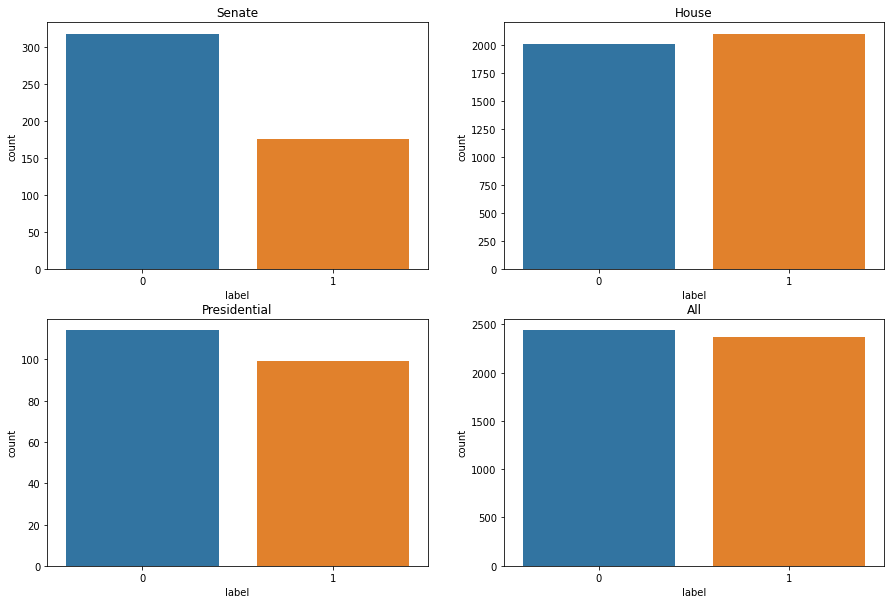

In [139]:
%matplotlib inline
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.countplot(df_senate['label'], ax=ax[0,0])
sns.countplot(df_house['label'], ax=ax[0,1])
sns.countplot(df_presidential['label'], ax=ax[1,0])
sns.countplot(df['label'], ax=ax[1,1])
ax[0,0].set_title('Senate')
ax[0,1].set_title('House')
ax[1,0].set_title('Presidential')
ax[1,1].set_title('All')
plt.show()